In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

saveas = 'pdf'
mpl.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']


if saveas == 'pgf':
    mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
else:
    #mpl.use('WXAgg')
    plt.rc('text', usetex=True)
    #plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    ## for Palatino and other serif fonts use:
    #rc('font',**{'family':'serif','serif':['Palatino']})
    #plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('font',**{'family':'serif','serif':['DejaVu Sans']})
    # hfont = {'fontname':'Computer Modern Roman'}

# Class for handling different files

In [2]:
class  Dataset:
    #t_quantile = 3 # for 3sigma = 99,730 0204 %
    t_quantile = 2.576 # for 2.576sigma = 99% 
    knownMu = False
    
    def __init__(self, filename, co):
        self.fname = filename
        self.name = (self.fname.split('/')[-1].split('.')[0])[9:15].lower()
        self.altname = ''
        self.cutoff = co
        self.n = 0
        self.Nbr = 0
        self.readFile() # "2018-11-18_01.txt"
        if "/small/" in filename:
            self.knownMu = True
            self.mu = 1.96197e-13 # just for small/FTODDUMP_MC
        elif "/large/" in filename:
            self.knownMu = True
            self.mu = 8.7593051e-13 # just for large/FTODDUMP_MC
        
    def printEntry(self, idx):
        print(np.array([self.x[idx], self.x_nbr[idx], self.mean[idx], self.var[idx], self.var_var[idx]]))
        

#### Read in file with data

In [3]:
def readFile(self):
    file  = open(self.fname, "r") 
    data = []
    x = []
    line = ""
    
    while (not line.startswith("0%") ):
        line = file.readline().rstrip("\n\r")    
        if line.startswith("nbrOfSamples"):
            self.n = int(line.split()[2])
        if line.startswith("maxi"):
            self.Nbr = int(line.split()[1])

    line += file.readline().rstrip("\n\r")
    lsplit = line.split()

    x.append(float(lsplit[0][:-2]))
    data.append([float(lsplit[2]),float(lsplit[5]),float(lsplit[7])])

    while ( lsplit[0] != "100%:"):
        line = file.readline().rstrip("\n\r")
        line += file.readline().rstrip("\n\r")
        lsplit = line.split()
        x.append(float(lsplit[0][:-2]))
        data.append([float(lsplit[2]),float(lsplit[5]),float(lsplit[7])])

    file.close()
    data = np.array(data)
    self.x = np.array(x)/100*self.n/self.Nbr
    
    reOrgData(self, data)    

#### reorganize read data

`data`-array contains `[mean, var, var_var]`  


`[x:]` --> cutting of first two values  where offset is still huge

In [4]:
def reOrgData(self, data):
    cutoff = 1

    self.mean = data[:,0]
    self.var = data[:,1]
    self.var_var = data[:,1]

    self.x = self.x[self.cutoff:]
    self.mean = self.mean[self.cutoff:]
    self.var = self.var[self.cutoff:]
    self.var_var = self.var_var[self.cutoff:]
    
    self.x_nbr = self.x*self.Nbr

#### bind functions to class

In [5]:
Dataset.readFile = readFile
Dataset.reOrgData = reOrgData

#### position of legend

In [6]:
def positioning(c):
    return {
        'ur': 'upper right',
        'lr': 'lower right',
        'cr': 'center right',
        'll': 'lower left',
        'ul': 'upper left',
        'cl': 'center left',
        'lc': 'lower center',
        'uc': 'upper center',
        'c': 'center'
    }[c]

# Plots

$y_{err}$ is the standard deviation

$$y_{err} = \sqrt{\mathtt{Var}(y)} =   \sqrt { \frac { \sum _ { i = 1 } ^ { N } \left( x _ { i } - \overline { x } \right) ^ { 2 } } { N - 1 } }$$

In [7]:
#Colorwheel
color = ['r','b', 'm', 'g', 'c', 'y', 'k', 'w']

# plot parameter
xAxisExpScalar = -3
figuresize = [8,6]

In [8]:
def plotMean(lst, legendpos='ur'):
    plotMeanlim(lst, xlim=(0.0,-1), ylim=(0,-1), legendpos=legendpos)

def plotMeanlim(lst, xlim=(0.0,-1), ylim=(0,-1), legendpos='ur'):
    
    exp = np.floor(np.log10(np.abs(lst[0].mean[0]))).astype(int)
    #print(exp)
    llimit, ulimit = xlim
    yllim, yulim = ylim
    
    plt.figure(figsize=figuresize)
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.145,right=0.95, bottom= 0.125,top=0.98)
    
    #title = 'mean'
    #plt.title(title)
    plt.rcParams.update({'font.size': 22})
    plt.ylabel(r'$\left\langle E^\mathrm{{MP2,1}} \right\rangle \qquad \left[10^{{{0}}}\right]$'.format(exp))
    plt.xlabel(r'$M_i / N \qquad \left[10^{{{0}}}\right]$'.format(xAxisExpScalar))
    
    # set drawing area
    max_x = 0
    for self in lst:
        if self.x[-1] > max_x:
            max_x = self.x[-1]
    if (ulimit != -1):
        max_x = ulimit
        
    # draw grid
    if yulim != -1:
        plt.ylim(yllim, yulim)
    else:
        plt.autoscale(enable=True, axis='y', tight=True)
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    color_counter = 0
    for self in lst:
        #plt.errorbar(self.x, self.mean,  yerr = np.sqrt(self.var/self.x_nbr), fmt= 'o', capsize=4)
        
        labelname = self.name
        if self.altname != '':
            labelname = self.altname
        
        if ulimit != -1:
            plt.plot(self.x[(self.x > llimit) & (self.x < ulimit)], self.mean[(self.x > llimit) & (self.x < ulimit)], 
                     marker = 'o',color = color[color_counter],  linestyle= 'solid', label=labelname)
        else:
            plt.plot(self.x, self.mean, marker = 'o', color = color[color_counter], linestyle= 'solid', label=labelname)
            
        color_counter = color_counter+1 if color_counter+1<len(color) else 0
    
    plt.legend(loc=positioning(legendpos))
    labels = plt.yticks()[0]
    #if lst[0].knownMu:
    #    plt.yticks(list(plt.yticks()[0]) + [lst[0].mu], list([round(float(label/10.0**exp), 4) for label in labels]) + ['$\mu$'])
    #else:
    #    plt.yticks(list(plt.yticks()[0]), list([round(float(label/10.0**exp), 4) for label in labels]))
    plt.yticks(list(plt.yticks()[0]), list([round(float(label/10.0**exp), 4) for label in labels]))
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlim(llimit, max_x)

    # draw mean
    if lst[0].knownMu:
        plt.hlines(lst[0].mu, 0, max_x, linestyle = 'dashed') #, label='$\mu$')
        plt.text(max_x*1.01, lst[0].mu, '$\mu$', verticalalignment='center')
    
    # lines of last data points
    #print(lst[0].x[-2], lst[0].x[-2]*lst[0].Nbr)
    #plt.hlines(1.96169e-13, 0, max_x, linestyle = 'dashdot') #, label='$\mu$')
    #plt.hlines(1.96151e-13, 0, max_x, linestyle = (0, (5, 10))) #, label='$\mu$')
    #plt.hlines(1.96220e-13, 0, max_x, linestyle = 'dotted') #, label='$\mu$')
    #plt.hlines(lst[2].mean[-2], 0, max_x, linestyle = (0, (3, 1, 1, 1, 1, 1))) #, label='$\mu$')
    
    if ulimit != -1:
        plt.savefig('{1}/mean_lim{0}.{2}'.format(additional_name, directory, saveas))
    else:
        plt.savefig('{1}/mean{0}.{2}'.format(additional_name, directory, saveas))
    
    plt.show()
    
#1.96169e-13 1.96151e-13 1.96220e-13
#plotMeanlim(ds_, xlimit=(0.0015, 0.0039), 'ur')
#plotMean(ds_, 'ur')
#plotMeanlim(ds_, xlimit=(0.001, 0.00391), 'ur')
# plotMeanlim(ds_, xlim=(0.0015, 0.0039), ylim=(1.955*10**(-13),1.997*10**(-13)), legendpos='ur')


###  Intervallschätzung
#### für $\alpha = 0.99$

Für den Spezialfall einer Normalverteilung können wir exakte Konfidenzintervalle angeben:  
Für $\mu$, wenn $\sigma^2$ bekannt ist:
$$ \left[ \overline { X } _ { n } - z _ { \frac { 1 + \gamma } { 2 } } \sqrt { \frac { \sigma ^ { 2 } } { n } } , \overline { X } _ { n } + z _ { \frac { 1 + \gamma } { 2 } } \sqrt { \frac { \sigma ^ { 2 } } { n } } \right] $$  

<br>

Für $\mu$ wenn $\sigma^2$ unbekannt ist:
$$\left[ \overline { X } _ { n } - t _ { n - 1 ; \frac { 1 + \gamma } { 2 } } \sqrt { \frac { S _ { n } ^ { 2 } } { n } } , \overline { X } _ { n } + t _ { n - 1 ; \frac { 1 + \gamma } { 2 } } \sqrt { \frac { S _ { n } ^ { 2 } } { n } } \right]$$  
Tabelle nur bis $n = 120$, danach $n = \infty$ verwendet. [Table](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Table_of_selected_values)  
$\dfrac{1-\gamma}{2} = \dfrac{1.99}{2} = 0.995  \quad \Longrightarrow \quad t_{\infty, 0.995} = 2.576$

<br>

für $\sigma^2$:
$$\left[ \frac { ( n - 1 ) S _ { n } ^ { 2 } } { \chi _ { n - 1 ; \frac { 1 + \gamma } { 2 } } ^ { 2 } } , \frac { ( n - 1 ) S _ { n } ^ { 2 } } { \chi _ { n - 1 ; \frac { 1 - \gamma } { 2 } } ^ { 2 } } \right]$$



In [9]:
ylimit_varUnderest = False
xlimit = (0,0)

def u_err(x, a, b, c):
    return a / np.power(np.sqrt(x), c) + b

def l_err(x, a, b, c):
        return - a / np.power(np.sqrt(x), c) + b
        

In [10]:
def MeanIntervallUnderest(lst, xlim = (0.0, -1), legendpos='ur'):
    xllim, xulim = xlim
    expsize = lst[0].t_quantile*np.sqrt((lst[0].var+np.sqrt(lst[0].var_var)/lst[0].x_nbr)/lst[0].x_nbr)[0]
    exp_y = np.floor(np.log10(np.abs(expsize))).astype(int)
    
    fig, ax = plt.subplots(figsize=figuresize)
    fig.tight_layout()
    plt.gcf().subplots_adjust(left=0.145,right=0.95, bottom= 0.125,top=0.99)
    plt.rcParams.update({'font.size': 22})
    ax.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    
    ax.set_ylabel(r'$\left\langle E^\mathrm{{MP2,1}} \right\rangle \qquad \left[10^{{{0}}}\right]$'.format(exp_y))
    ax.set_xlabel(r'$M_i / N \qquad \left[10^{{{0}}}\right]$'.format(xAxisExpScalar))
    global xlimit
    if xulim == -1:
        for self in lst:
            if self.x[-1] > xulim:
                xulim = self.x[-1]
        if xlimit[1] < xulim: 
            xlimit = (xlimit[0], xulim)
    plt.xlim(0, xulim)
    
    color_counter = 0
    alpha = 0.4
    alpha_fit= 0.5
    for self in lst:
        #statistical data calculation
        var_deviantion = self.t_quantile*np.sqrt((self.var_var)/self.x_nbr)
        mean_deviation = ( self.t_quantile*np.sqrt((self.var)/self.x_nbr) )
        x_red = self.x[(self.x > xllim) & (self.x < xulim)]
        mean_red = self.mean[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        mean_deviation = mean_deviation[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        
        labelname = self.name
        if self.altname != '':
            labelname = self.altname
        
        #plot differen runs
        ax.plot(x_red, mean_red, marker = 'o', color = color[color_counter], linestyle= 'solid', label=labelname, alpha = alpha)
        ax.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color = color[color_counter], capsize=4, capthick=1.5 ,elinewidth=0.5, alpha = alpha)
                
        color_counter = color_counter+1 if color_counter+1<len(color) else 0
    
    if lst[0].knownMu:
        print("mean known:", lst[0].mu)
        ax.hlines(lst[0].mu/(10.0**exp_y),0, xulim, linestyle = 'dashed', color = 'black')
        plt.text(xulim*1.01, lst[0].mu/(10.0**exp_y), '$\mu$', verticalalignment='center')
    
    
    
    global ylimit_varUnderest
    ylimit_varUnderest =  plt.ylim()
    print(ylimit_varUnderest)
    ax.legend(loc=positioning(legendpos))
    ax.set_xticklabels(list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in ax.get_xticks()]))
    plt.draw()
    plt.savefig('{1}/meanIntervallUnderest{0}-{2}.{3}'.format(additional_name, directory, len(lst), saveas))
    plt.show()

#MeanIntervallUnderest(ds_[:])

In [11]:
def MeanIntervallEst(lst, xlim = (0.0, -1), ylim = False, legendpos='ur', mvy=0.0):
    xllim, xulim = xlim
    expsize = lst[0].t_quantile*np.sqrt((lst[0].var+np.sqrt(lst[0].var_var)/lst[0].x_nbr)/lst[0].x_nbr)[0]
    exp_y = np.floor(np.log10(np.abs(expsize))).astype(int)
    
    fig, ax = plt.subplots(figsize=figuresize)
    fig.tight_layout()
    plt.gcf().subplots_adjust(left=0.145,right=0.95, bottom= 0.125,top=0.99)
    plt.rcParams.update({'font.size': 22})
    ax.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    
    ax.set_ylabel(r'$\left\langle E^\mathrm{{MP2,1}} \right\rangle \qquad \left[10^{{{0}}}\right]$'.format(exp_y))
    ax.set_xlabel(r'$M_i / N \qquad \left[10^{{{0}}}\right]$'.format(xAxisExpScalar))

    global xlimit
    if xulim == -1:
        for self in lst:
            if self.x[-1] > xulim:
                xulim = self.x[-1]
        if xlimit[1] < xulim: 
            xlimit = (xlimit[0], xulim)
    plt.xlim(0, xulim)
    
    if ylim != False:
        plt.ylim(tuple(t+mvy for t in ylim))   
    
    color_counter = 0
    alpha = 0.7
    alpha_fit= 0.5
    for self in lst:
        
        #statistical data calculation
        #var_deviantion = self.t_quantile*np.sqrt((self.var_var)/self.x_nbr)
        #mean_deviation = ( self.t_quantile*np.sqrt((self.var+var_deviantion)/self.x_nbr) )
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        
        x_red = self.x[(self.x > xllim) & (self.x < xulim)]
        mean_red = self.mean[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        mean_deviation = mean_deviation[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        
        labelname = self.name
        if self.altname != '':
            labelname = self.altname
        
        #plot differen runs
        ax.plot(x_red, mean_red, marker = 'o', color = color[color_counter], linestyle= 'solid', 
                label=labelname, alpha = alpha)
        ax.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color = color[color_counter], 
                    capsize=4, capthick=1.5 ,elinewidth=0.5, alpha = alpha)
        
        
        #encveloping curve
        popt_u, pcov_u = opt.curve_fit(u_err, x_red, (mean_red + mean_deviation), maxfev=1000)
        
        ax.plot(x_red, u_err(x_red, *popt_u), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        ax.plot(x_red, 2*mean_red[-1]-u_err(x_red, *popt_u), color='gray', marker = '', linestyle= 'solid', 
                alpha=alpha_fit)
        #ax.plot(x_red, lower_err(x_red, *poptl), color='gray', marker = '', linestyle= 'solid', alpha=0.7)
        
        color_counter = color_counter+1 if color_counter+1<len(color) else 0
    
    if lst[0].knownMu:
        print("mean known:", lst[0].mu)
        ax.hlines(lst[0].mu/(10.0**exp_y),0, xulim, linestyle = 'dashed', color = 'black')
        plt.text(xulim*1.01, lst[0].mu/(10.0**exp_y), '$\mu$', verticalalignment='center')
    
    ax.legend(loc=positioning(legendpos)) 
    ax.set_xticklabels(list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in ax.get_xticks()]))
    
    
    plt.draw()
    if ylim == False:
        plt.savefig('{1}/meanIntervallEst{0}-{2}.{3}'.format(additional_name, directory, len(lst), saveas))
    else:
        plt.savefig('{1}/meanIntervallEstLim{0}-{2}.{3}'.format(additional_name, directory, len(lst), saveas))
    plt.show()

#MeanIntervallEst(ds_[:], ylim = ylimit_varUnderest)
#MeanIntervallEst(ds_[:])
#MeanIntervallEst(ds_[:], ylim = ylimit_varUnderest, legendpos='ul', mvy = 0.04)

In [12]:
'''loc: zoom_inset_axes
'upper right'  : 1,
'upper left'   : 2,
'lower left'   : 3,
'lower right'  : 4,
'right'        : 5,
'center left'  : 6,
'center right' : 7,
'lower center' : 8,
'upper center' : 9,
'center'       : 10
'''


def MeanIntervallEstZoom(lst, x, y, zoomfactor, xlim = False, ylim = False, legendpos='lr', zoompos='ur',mvy=0.0):
    expsize = lst[0].t_quantile*np.sqrt((lst[0].var+np.sqrt(lst[0].var_var)/lst[0].x_nbr)/lst[0].x_nbr)[0]
    exp_y = np.floor(np.log10(np.abs(expsize))).astype(int)
    
    fig, ax = plt.subplots(figsize=figuresize)
    fig.tight_layout()
    plt.gcf().subplots_adjust(left=0.145,right=0.95, bottom= 0.135,top=0.99)
    plt.rcParams.update({'font.size': 22})
    ax.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    
    ax.set_ylabel(r'$\left\langle E^\mathrm{{MP2,1}} \right\rangle \qquad \left[10^{{{0}}}\right]$'.format(exp_y))
    ax.set_xlabel(r'$M_i / N \qquad \left[10^{{{0}}}\right]$'.format(xAxisExpScalar))

    if xlim == False:
        xllim = 0
        xulim = 0
        for self in lst:
            if self.x[-1] > xulim:
                xulim = self.x[-1]
    else: 
        xllim, xulim = xlim
    plt.xlim(0, xulim)
    
    if lst[0].knownMu:
        plt.text(xulim*1.01, lst[0].mu/(10.0**exp_y), '$\mu$', verticalalignment='center')
    
    if ylim != False:
        plt.ylim(tuple(t+mvy for t in ylim))
    
    axins = zoomed_inset_axes(ax, zoomfactor, loc=positioning(zoompos))
    axins.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    color_counter = 0
    alpha = 0.7
    alpha_fit= 0.5

    for self in lst:
        #statistical data calculation
        var_deviantion = self.t_quantile*np.sqrt((self.var_var)/self.x_nbr)
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        x_red = self.x[(self.x > xllim) & (self.x < xulim)]
        mean_red = self.mean[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        mean_deviation = mean_deviation[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        
        labelname = self.name
        if self.altname != '':
            labelname = self.altname
        
        #plot differen runs
        ax.plot(x_red, mean_red, marker = 'o', color = color[color_counter], linestyle= 'solid', label=labelname, alpha = alpha)
        ax.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color = color[color_counter], capsize=4, capthick=1.5 ,elinewidth=0.5, alpha = alpha)
                
        axins.plot(x_red, mean_red, marker = 'o', color = color[color_counter], linestyle= 'solid', label=labelname, alpha = alpha)
        axins.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color = color[color_counter], capsize=4, capthick=1.5 ,elinewidth=0.5, alpha = alpha)
        
        popt_u, pcov_u = opt.curve_fit(u_err, x_red, (mean_red + mean_deviation), maxfev=1000)
        
        ax.plot(x_red, u_err(x_red, *popt_u), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        ax.plot(x_red, 2*mean_red[-1]-u_err(x_red, *popt_u), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        axins.plot(x_red, u_err(x_red, *popt_u), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        axins.plot(x_red, 2*mean_red[-1]-u_err(x_red, *popt_u), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        
        color_counter = color_counter+1 if color_counter+1<len(color) else 0
   
        
    axins.set_xlim(*x)
    axins.set_ylim(*y) # Limit the region for zoom
    
    loc1=3
    loc2=1
    plt.xticks(visible=False)  # Not present ticks
    plt.yticks(visible=True)
    if zoompos[-1]=='l':
        axins.yaxis.tick_right()
    
    
    if lst[0].knownMu:
        print("mean known:", lst[0].mu)
        ax.hlines(lst[0].mu/(10.0**exp_y),0, xulim, linestyle = 'dashed', color = 'black')
        axins.hlines(lst[0].mu/(10.0**exp_y),0, xulim, linestyle = 'dashed', color = 'black')
        #plt.text(xulim*1.01, lst[0].mu/(10.0**exp_y), '$\mu$', verticalalignment='center')
       
    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc='grey', ec="0.5",alpha=0.3)
    
    ax.legend(loc=positioning(legendpos)) 
    
    #print(ax.get_xticks())
    #print(list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in ax.get_xticks()]))
    ax.set_xticklabels(list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in ax.get_xticks()]))
    
    plt.draw()
    if ylim == False:
        plt.savefig('{1}/meanIntervallEstZoom{0}-{2}.{3}'.format(additional_name, directory, len(lst), saveas))
        print("stored at: '{1}/meanIntervallEstZoom{0}-{2}.{3}'".format(additional_name, directory, len(lst), saveas))
    else:
        plt.savefig('{1}/meanIntervallEstZoomLim{0}-{2}.{3}'.format(additional_name, directory, len(lst), saveas))
        print("stored at: '{1}/meanIntervallEstZoomLim{0}-{2}.{3}'".format(additional_name, directory, len(lst), saveas))
    plt.show()


#MeanIntervallEstZoom(ds_[:2], x=(0.0033, 0.0035), y=(1.8, 2.1), zoomfactor = 14, legendpos='l')
#MeanIntervallEstZoom(ds_[:], x=(0.0030, xlimit[1]), y=(0.178, 0.218), ylim = ylimit_varUnderest, zoomfactor = 2, legendpos='ul', zoompos='ur',mvy=0.04)

### Tests


Für den Mittelwert einer Normalverteilung, wenn $\sigma^2$ unbekannt ist:
$$T = \frac { \overline { X } _ { n } - \mu _ { 0 } } { \sqrt { S _ { n } ^ { 2 } / n } }$$  

$H _ { 0 } : \mu \leq \mu _ { 0 } $ gegen $ H _ { 1 } : \mu > \mu _ { 0 } : $ verwerfen, wenn $ T > t _ { n - 1 ; 1 - \alpha }$  
$H _ { 0 } : \mu \geq \mu _ { 0 } $ gegen $ H _ { 1 } : \mu < \mu _ { 0 } : $ verwerfen, wenn $ T < - t _ { n - 1 ; 1 - \alpha }$  
$H _ { 0 } : \mu = \mu _ { 0 } $ gegen $ H _ { 1 } : \mu \neq \mu _ { 0 } : $ verwerfen, wenn $ | T | > t _ { n - 1 ; 1 - \alpha / 2 }$

<br><br>  

Für die Varianz einer Normalverteilung:
$$T = \frac { ( n - 1 ) S _ { n } ^ { 2 } } { \sigma _ { 0 } ^ { 2 } }$$

$H _ { 0 } : \sigma ^ { 2 } \geq \sigma _ { 0 } ^ { 2 } $ gegen $ H _ { 1 } : \sigma ^ { 2 } < \sigma _ { 0 } ^ { 2 } : $ verwerfen, wenn $ T < \chi _ { n - 1 ; \alpha } ^ { 2 }$  
$H _ { 0 } : \sigma ^ { 2 } = \sigma _ { 0 } ^ { 2 } $ gegen $ H _ { 1 } : \sigma ^ { 2 } \neq \sigma _ { 0 } ^ { 2 } : $ verwerfen, wenn $ T > \chi _ { n - 1 ; 1 - \alpha / 2 } ^ { 2 } $ oder $ T < \chi _ { n - 1 ; \alpha / 2 } ^ { 2 }$  
$H _ { 0 } : \sigma ^ { 2 } \leq \sigma _ { 0 } ^ { 2 } $ gegen $ H _ { 1 } : \sigma ^ { 2 } > \sigma _ { 0 } ^ { 2 } : $ verwerfen, wenn $ T > \chi _ { n - 1 ; 1 - \alpha } ^ { 2 }$

In [13]:
def MeanTest(lst, legendpos='ur'):
    plt.figure(figsize=figuresize)
    plt.rcParams.update({'font.size': 22})
    plt.ylabel(r'$T$')
    plt.xlabel(r'$M_i / N \qquad \left[10^{{{0}}}\right]$'.format(xAxisExpScalar))
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.24,right=0.95, bottom= 0.135,top=0.99)
    # set drawing area
    maxx = 0
    for self in lst:
        if self.x[-1] > maxx:
            maxx = self.x[-1]
    
        
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    plt.hlines(lst[0].t_quantile, 0, maxx, linestyle = 'dashed')
    plt.hlines(-lst[0].t_quantile, 0, maxx, linestyle = 'dashed')
    
    
    #plt.yticks(list(plt.yticks()) + [lst[0].t_quantile, -lst[0].t_quantile])    
    #print(plt.yticks())
    
    color_counter = 0
    
    for self in lst:
        T = (self.mean-self.mu)/np.sqrt((self.var)/self.x_nbr)
        #T = (self.mean-self.mu)/(np.sqrt((self.var + np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr))
        
        labelname = self.name
        if self.altname != '':
            labelname = self.altname
        
        plt.plot(self.x, T, marker = 'o', color = color[color_counter], linestyle= 'solid', label=labelname)
        color_counter = color_counter+1 if color_counter+1<len(color) else 0
        
    plt.legend(loc=positioning(legendpos))
    labels = plt.yticks()[0]
    plt.yticks(list(plt.yticks()[0]) + [lst[0].t_quantile] + [ -lst[0].t_quantile], list([round(float(label), 4) for label in labels]) + ['$t_{n-1;1-\\alpha/2}$', '$-t_{n-1;1-\\alpha/2}$'])
    
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlim(0,  maxx)
    
    plt.savefig('{1}/t-Test{0}-{2}.{3}'.format(additional_name,directory,len(lst), saveas))
    plt.show()
    
#MeanTest(ds_)

In [14]:
def plot_var(lst, llimit = 0.0, ulimit = -1, legendpos='ur'):
    exp = np.floor(np.log10(np.abs(lst[0].var[-1]))).astype(int)
    print(np.sqrt(lst[0].var[-1]))
    
    plt.figure(figsize=figuresize)
    plt.rcParams.update({'font.size': 22})
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.16,right=0.99, bottom= 0.135,top=0.98)
    #plt.title('var over # sampled ')
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    plt.ylabel(r'$S^2_{{E^\mathrm{{MP2,1}}}} \qquad \left[10^{{{0}}}\right]$'.format(exp))
    plt.xlabel(r'$M_i / N \qquad \left[10^{{{0}}}\right]$'.format(xAxisExpScalar))
        
     # set drawing area
    maxx = 0
    for self in lst:
        if self.x[-1] > maxx:
            maxx = self.x[-1]
    plt.xlim(0, maxx)
    if (ulimit != -1):
        plt.xlim(llimit, ulimit)    
    
    #plt.yticks(list(plt.yticks()) + [lst[0].t_quantile, -lst[0].t_quantile])    
    #print(plt.yticks())
    
    
    color_counter = 0
    
    for self in lst:
        
        labelname = self.name
        if self.altname != '':
            labelname = self.altname
            
        #plt.errorbar(self.x, self.var,  yerr = self.t_quantile*np.sqrt(self.var_var/self.x_nbr), fmt= 'o', capsize=4)
        if ulimit != -1:
            plt.plot(self.x[(self.x > llimit) & (self.x < ulimit)], self.var[(self.x > llimit) & (self.x < ulimit)], 
                     marker = 'o', color = color[color_counter], linestyle= 'solid', label=labelname)
        else:
            plt.plot(self.x, self.var, marker = 'o', color = color[color_counter], linestyle= 'solid', label=labelname)
        color_counter = color_counter+1 if color_counter+1<len(color) else 0
        
    plt.yscale('log')
    ylabels = plt.yticks()[0]
    plt.yticks(ylabels, list([round(float(ylabel/10.0**exp), 4) for ylabel in ylabels]) )
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend(loc=positioning(legendpos))
    
    
    plt.savefig('{1}/variance{0}-{2}.{3}'.format(additional_name, directory, len(lst), saveas))
    plt.show()
    
#plot_var(ds_, legendpos='ur')

In [15]:
def plot_fitConfi(self, legendpos='ur'):
    exp = np.floor(np.log10(np.abs(self.var[-1]))).astype(int)
    
    plt.figure(figsize=figuresize)
    plt.rcParams.update({'font.size': 22})
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.145,right=0.95, bottom= 0.135,top=0.99)
    #plt.title('var over # sampled ')
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    plt.ylabel(r'$S^2_{{E^\mathrm{{MP2,1}}}} \quad \left[10^{{{0}}}\right]$'.format(exp))
    plt.xlabel(r'$M_i / N \qquad \left[10^{{{0}}}\right]$'.format(xAxisExpScalar))
        
    labelname = self.name
    if self.altname != '':
            labelname = self.altname
    
    #plt.errorbar(self.x, self.var,  yerr = self.t_quantile*np.sqrt(self.var_var/self.x_nbr), fmt= 'o', capsize=4)
    plt.plot(self.x, self.var, marker = 'o', linestyle= 'solid', label=self.name)
    
    plt.legend(loc=positioning(legendpos))
    
    ylabels = plt.yticks()[0]
    plt.yticks(ylabels, list([round(float(ylabel/10.0**exp), 4) for ylabel in ylabels]) )
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel)/(10**xAxisExpScalar), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    
    
    #plt.savefig('{1}/fitVar{0}-{2}.{3}'.format(additional_name, directory, len(lst), saveas))
    plt.show()
    
#plot_fitConfi(ds_, 'c')

### Sampling Order & Datafile reducer for more visability

In [16]:
def getSampleTypes(flist, types):
    if len(types) == 0:
        return flist
    flist = np.array(flist)
    sampleType = [s.split('_')[1] for s in flist]
    sampleType = np.array(sampleType)
    fname = flist[np.isin(sampleType, types)]
    return fname

def getSampleDates(flist, dates):
    if len(dates) == 0:
        return flist
    flist = np.array(flist)
    sampleType = [s.split('_')[0] for s in flist]
    sampleType = np.array(sampleType)
    fname = flist[np.isin(sampleType, dates)]
    return fname

# Main

In [17]:
print('List of all data-files:')
folder = "./data/small/"
#folder = "./data/large/"

flist = os.listdir(folder)
print(np.array(flist))

print('\nTypes to choose from:')
samplingType = np.unique([s.split('_')[1] for s in flist])
print(samplingType)

List of all data-files:
['18-02-08_uuuuuu_02.txt' '19-05-21_uccucc_03.txt'
 '18-02-06_cutccc_01.txt' '19-05-21_uccucc_01.txt'
 '18-02-14_ttuccc_06.txt' '18-02-20_ttuccc_02.txt'
 '18-02-14_ttuccc_03.txt' '19-05-21_ttTccc_02.txt'
 '18-02-20_cutccc_02.txt' '19-05-26_cutccc_01.txt'
 '19-05-26_ttuccc_02.txt' '19-05-20_ttTccc_02.txt'
 '18-02-05_ucctuu_03.txt' '18-02-05_ucctuu_02.txt'
 '19-05-20_ttTccc_01.txt' '18-02-08_uuuuuu_01.txt'
 '19-05-26_cutccc_03.txt' '18-02-05_uccucc_01.txt'
 '18-02-13_ttuccc_03.txt' '18-02-05_cutccc_01.txt'
 '19-05-21_uccucc_02.txt' '18-02-14_ttuccc_02.txt'
 '18-02-05_ucctuu_01.txt' '18-02-20_cutccc_01.txt'
 '19-05-26_cutccc_02.txt' '18-02-14_ttuccc_05.txt'
 '18-02-14_ttuccc_01.txt' '18-02-13_ttuccc_02.txt'
 '19-05-20_ttTccc_03.txt' '19-05-26_ttuccc_03.txt'
 '18-02-14_ttuccc_04.txt' '19-05-21_ttTccc_01.txt'
 '18-02-05_uccucc_02.txt' '18-02-13_ttuccc_01.txt'
 '18-02-08_cutccc_01.txt' '18-02-20_ttuccc_01.txt'
 '19-05-26_ttuccc_01.txt' '18-02-05_cutccc_02.txt']

Types

In [18]:
translationtable = np.array([['uccucc', 'method 1'], ['tttccc', 'method 2']])

samplingTyp_list = ['uccucc'] # ['ttTccc', 'uccucc', 'uuuuuu','ttuccc']
samplingTyp_list = ['ttTccc']
# samplingTyp_list = ['uccucc', 'ttTccc'] 
#samplingTyp_list = ['uccucc', 'ttTccc', 'cutccc', 'ttuccc'] 
#samplingTyp_list = ['uccucc', 'ttTccc', 'cutccc', 'ttuccc', 'ucctuu'] 

#samplingTyp_list = ['uccccc', 'ccTccc'] 

additional_name = '-'+'-'.join(str(s) for s in samplingTyp_list)

directory = './graphs/{0}'.format(folder[7:-1])
if not os.path.exists(directory):
    os.makedirs(directory)
directory += '/{0}'.format(additional_name[1:])
if not os.path.exists(directory):
    os.makedirs(directory)

flist_red = getSampleDates(getSampleTypes(flist, samplingTyp_list), [])

print('--------------------', flist_red.shape[0], 'files --------------------')
print(flist_red)
print('\nfolder:', directory, 'exists {0}'.format(os.path.exists(directory)), '\t --- \t', 'nameaddition:', additional_name)

-------------------- 5 files --------------------
['19-05-21_ttTccc_02.txt' '19-05-20_ttTccc_02.txt'
 '19-05-20_ttTccc_01.txt' '19-05-20_ttTccc_03.txt'
 '19-05-21_ttTccc_01.txt']

folder: ./graphs/small/ttTccc exists True 	 --- 	 nameaddition: -ttTccc


In [19]:
fname = [folder + file for file in flist_red]
Dset = [Dataset(i, 1) for i in fname]

nbrEntriesOfDsets = [Dset[i].n for i in range(len(Dset))]
nbrEntriesOfDsets = np.array(nbrEntriesOfDsets)

if not np.all(nbrEntriesOfDsets == nbrEntriesOfDsets[0]):
    print("\nNOT ALL DATASETS HAVE THE SAME ENTRY NUMBER  ==> splitUp!\n")

Dset = np.array(Dset)
splitDs = [Dset[nbrEntriesOfDsets == i] for i in np.unique(nbrEntriesOfDsets)]

for j in range(len(splitDs)):
    print(str(j) + ": ", '#' + str(len(splitDs[j])), splitDs[j][0].n, splitDs[j][0].n/splitDs[j][0].Nbr,
          [i.fname.split('/')[-1].split(".")[0].split('_')[1] for i in splitDs[j]])

0:  #5 1167998976 0.00390625 ['ttTccc', 'ttTccc', 'ttTccc', 'ttTccc', 'ttTccc']


In [20]:
ds = np.hstack(splitDs[:])

if samplingTyp_list == ['uccucc'] :
    ds_= ds
    ds_ = np.hstack(splitDs[1]) #uccucc
    
    
elif samplingTyp_list == ['ttTccc']:
    ds_ = ds
    ds_ = np.delete(ds, [1,4]) #tttccc
    
elif samplingTyp_list == ['uccucc', 'ttTccc'] :
    ds = np.hstack(splitDs[1]) #uccucc
    ds_ = ds
    ds_ = np.delete(ds, [2,6])
    
else:
    ############# select files with number of samples #############
    ds = np.hstack(splitDs[1])
    ds_= ds

    
    
    
['{0}: {1}'.format(i.fname.split('_')[1], i.Nbr) for i in ds_], ds_.shape

(['ttTccc: 299007737856', 'ttTccc: 299007737856', 'ttTccc: 299007737856'],
 (3,))

In [21]:
# setting alternativ names (altname)
usealtnames = True
altnames = np.array([])
if samplingTyp_list == ['uccucc'] :    
    altnames = np.array(['run 1', 'run 2', 'run 3'])
elif samplingTyp_list == ['ttTccc']:
    altnames = np.array(['run 1', 'run 2', 'run 3'])
elif samplingTyp_list == ['uccucc', 'ttTccc'] :
    altnames = np.array(['1 run 1', '1 run 2', '2 run 1', '2 run 2', '2 run 3', '1 run 3'])

    
if altnames.shape[0] != ds_.shape[0] and usealtnames:
    raise ValueError('If you want to use altnames then size must be the same as ds_!')

for i in range(altnames.shape[0]):
    ds_[i].altname = altnames[i]

In [22]:
mean_r = []
var_r = []
mean_r_alt = []
var_r_alt = []
    
for self in ds_:
    mean_r.append(self.mean[-1])
    mean_r_alt.append(self.mean[-2])
    var_r.append(self.var[-1])
    var_r_alt.append(self.var[-2])
        
mean_r = np.array(mean_r)
var_r = np.array(var_r)

print(mean_r, np.mean(mean_r), np.mean(mean_r_alt))
print(var_r, np.mean(var_r), np.mean(var_r_alt))
print(np.sqrt(var_r), np.sqrt(np.mean(var_r)), np.sqrt(np.mean(var_r_alt)))
print('\n')

#tabel = np.vstack( (np.array(mean_r.append(0*np.mean(mean_r)), np.array([var_r,0*np.mean(var_r)]))))
names = np.array([i.name for i in ds_])
if ds_[0].knownMu:
    tabel = np.vstack(( names,
                        mean_r,
                        mean_r - ds_[0].mu,
                        var_r,
                        var_r/10**(-21),
                        ds_[0].t_quantile*np.sqrt(var_r / ds_[0].x_nbr[-1])
                     )).T

    #tabel = np.hstack((tabel,))
    
    #print(tabel)



#print(np.mean(mean_r) - ds_[0].mu, mean_r - ds_[0].mu)
print(tabel)
#np.sort(tabel.view('f8,f8,f8'), order=['f1'], axis=0).view(np.float)

[1.95929e-13 1.95791e-13 1.96186e-13] 1.9596866666666665e-13 1.95965e-13
[9.68619e-23 9.67890e-23 9.68273e-23] 9.682606666666667e-23 9.681263333333334e-23
[9.84184434e-12 9.83814007e-12 9.84008638e-12] 9.840023712708555e-12 9.839341102600993e-12


[['tttccc' '1.95929e-13' '-2.6799999999998937e-16' '9.68619e-23'
  '0.0968619' '7.418244094734952e-16']
 ['tttccc' '1.95791e-13' '-4.0600000000000857e-16' '9.6789e-23'
  '0.096789' '7.415452017639251e-16']
 ['tttccc' '1.96186e-13' '-1.0999999999988543e-17' '9.68273e-23'
  '0.0968273' '7.416919042412364e-16']]


0.00390625
plotMeanlim:



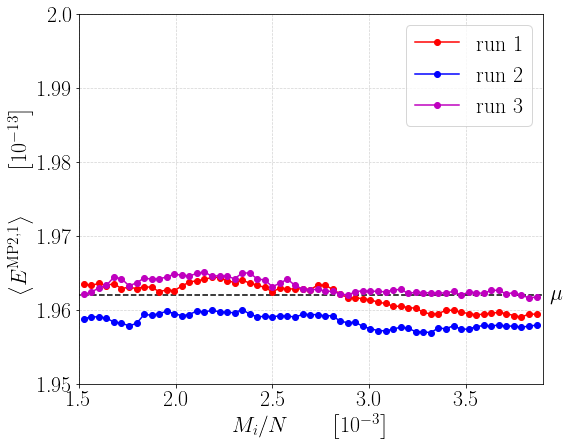

plotMean:



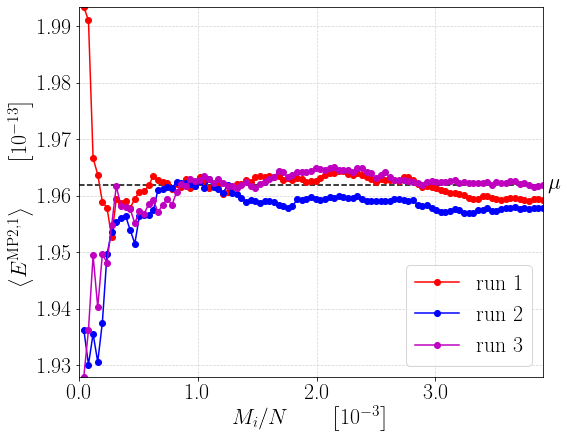

MeanIntervallUnderest:

mean known: 1.96197e-13
(1.8423231117881007, 2.079023119984243)


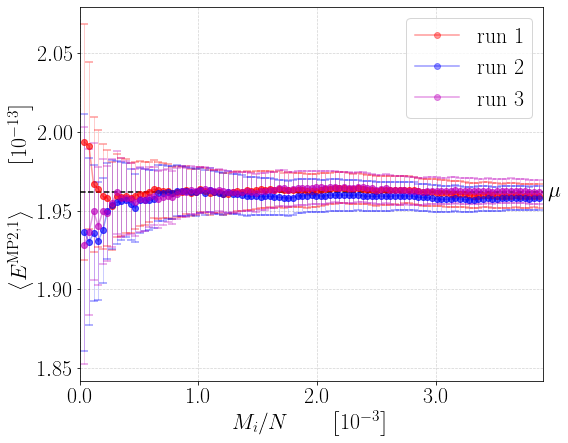

MeanIntervallEst:

mean known: 1.96197e-13


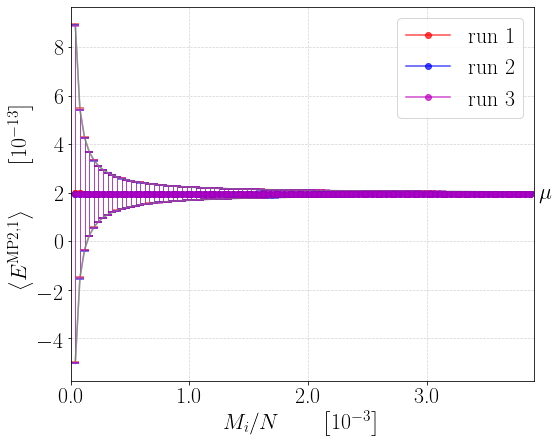

mean known: 1.96197e-13


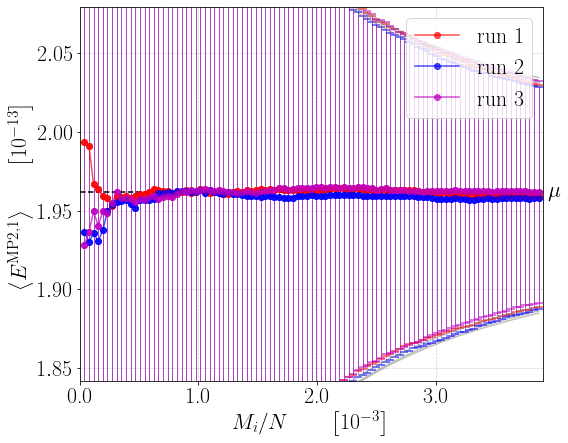

In [23]:
print(ds_[0].x[-1])
print('plotMeanlim:\n')
plotMeanlim(ds_, xlim=(0.0015, 0.0039), ylim=(1.9555*10**(-13),1.997*10**(-13)), legendpos='ur')
#plotMeanlim(ds_[[-1,-2,3,5,9,10]], [0.0015, 0.0039])
print('plotMean:\n')
plotMean(ds_, 'lr')
print('MeanIntervallUnderest:\n')
MeanIntervallUnderest(ds_[:])
print('MeanIntervallEst:\n')
MeanIntervallEst(ds_[:])

MeanIntervallEst(ds_[:], ylim = ylimit_varUnderest)



if samplingTyp_list == ['uccucc'] :
    print('MeanIntervallEst:\n')
    MeanIntervallEst(ds_[:], ylim = (0.19,0.205))
    
elif samplingTyp_list == ['ttTccc']:
    print()
    
elif samplingTyp_list == ['uccucc', 'ttTccc'] :
    print()

else:
    print()

MeanIntervallEst:

mean known: 1.96197e-13


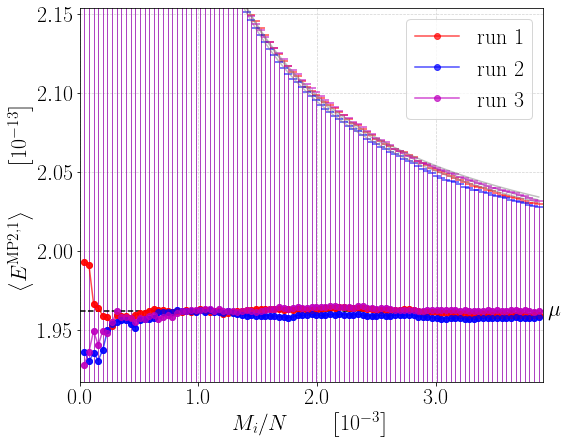

MeanIntervallEstZoom:

mean known: 1.96197e-13
stored at: './graphs/small/ttTccc/meanIntervallEstZoomLim-ttTccc-3.pdf'


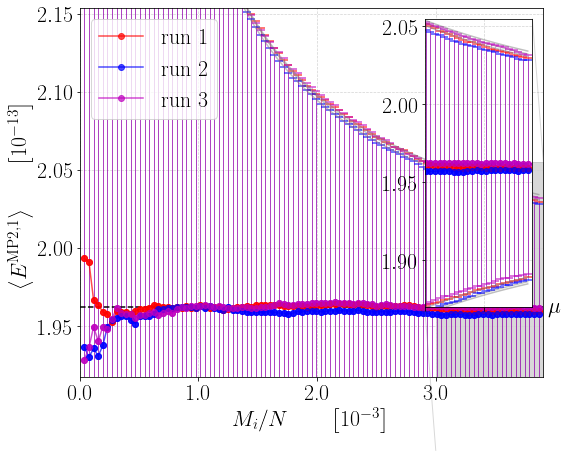

MeanTest:



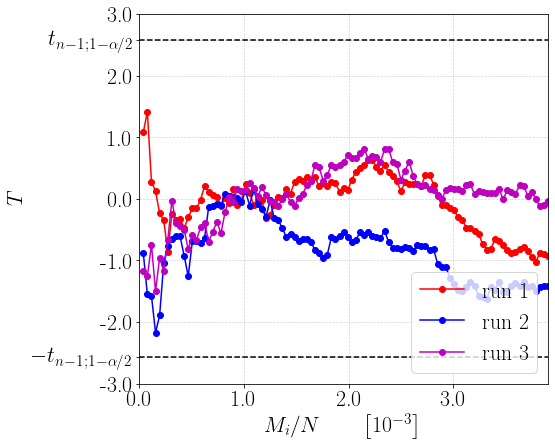

plot_var:

9.841844339350221e-12


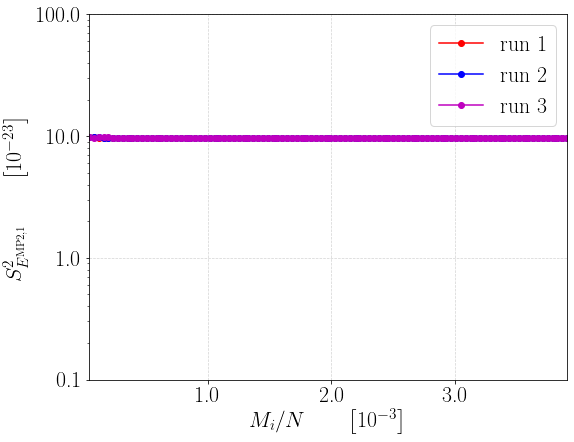

In [24]:
if len(samplingTyp_list) == 1 and samplingTyp_list == ['uccucc'] :
    #uccucc
    print('MeanIntervallEstZoom:\n')
    MeanIntervallEstZoom(ds_[:], x=(0.00343, 0.00353), y=(0.175, 0.22), zoomfactor = 30, legendpos='lr') 
    print('MeanIntervallEst:\n')
    MeanIntervallEst(ds_[:], ylim = ylimit_varUnderest, legendpos='ur', mvy = 0.04)
    print('MeanIntervallEstZoom:\n')
    MeanIntervallEstZoom(ds_[:], x=(0.0028, xlimit[1]), y=(0.175, 0.22), zoomfactor = 1.8, ylim = ylimit_varUnderest, legendpos='ul', mvy = 0.04)
    
elif len(samplingTyp_list) == 1 and samplingTyp_list == ['ttTccc']:
    #tttccc
    print('MeanIntervallEst:\n')
    MeanIntervallEst(ds_[:], ylim = ylimit_varUnderest, legendpos='ur', mvy = 0.075)
    print('MeanIntervallEstZoom:\n')
    MeanIntervallEstZoom(ds_[:], x=(0.0030, xlimit[1]), y=(1.87, 2.055), ylim = ylimit_varUnderest, zoomfactor = 1, legendpos='ul', zoompos='ur',mvy=0.075)

elif len(samplingTyp_list) == 2 and samplingTyp_list == ['uccucc', 'ttTccc'] :
    #uccucc-tttccc
    print('MeanIntervallEst:\n')
    MeanIntervallEst(ds_[:], ylim = ylimit_varUnderest, mvy=0.015)
    #MeanIntervallEstZoom(ds_[:], x=(0.00343, 0.00352), y=(0.175, 0.22), zoomfactor = 35, legendpos='lr') 
    print('MeanIntervallEstZoom:\n')
    MeanIntervallEstZoom(ds_[:], x=(0.0030, xlimit[1]), y=(0.178, 0.218), ylim = ylimit_varUnderest, zoomfactor = 1.0, legendpos='ul', zoompos='ur',mvy=0.015)

    
    ds_alt = ds_[[0,2]]
    ds_alt[0].altname = 'Method 1'
    ds_alt[1].altname = 'Method 2'
    
    print('MeanIntervallEst:\n')
    MeanIntervallEst(ds_alt, ylim = ylimit_varUnderest, mvy=0.015)
    print('MeanIntervallUnderest:\n')
    MeanIntervallUnderest(ds_alt)
    print('MeanIntervallEstZoom:\n')
    MeanIntervallEstZoom(ds_alt, x=(0.00343, 0.00352), y=(0.175, 0.22), zoomfactor = 35, legendpos='lr') 
    print('MeanIntervallEstZoom:\n')
    MeanIntervallEstZoom(ds_alt, x=(0.0030, xlimit[1]), y=(0.178, 0.218), ylim = ylimit_varUnderest, zoomfactor = 1.8, legendpos='ul', zoompos='ur',mvy=0.015)
    
    
    plot_var(ds_alt,'lr')
else:
    print()



#all
#MeanIntervallEstZoom(ds_[:], x=(0.003475, 0.003516), y=(1.86, 2.06), zoomfactor = 80, legendpos='lr')
#MeanIntervallEstZoom(ds_[:], x=(0.0030, xlimit[1]), y=(1.85, 2.07), ylim = ylimit_varUnderest, zoomfactor = 2, legendpos='ll', zoompos='ur')


#MeanIntervallEst(ds_[:])
#MeanIntervallEstlim(ds_[:],0.001, 0.0035)
#MeanIntervallEst(ds_[[-2]])

print('MeanTest:\n')
MeanTest(ds_,'lr')

print('plot_var:\n')
plot_var(ds_,'lr')
# plot_var(ds_[[1,2,3,5]],'cr)
#plot_var(ds_[8:],'cr')